In [1]:
import pandas as pd
import random

# 读取 trainmap.csv 文件
data = pd.read_csv('/trainmap.csv')

# 随机增加范围在0.1至0.5之间的偏移量
data.loc[data['sample_type'] == 'disease tissue', 'age'] += random.uniform(0.1, 0.5)

# # 将 "age" 列转换为整数数据类型
# data['age'] = data['age'].astype(int)

# 将修改后的数据保存到新的 CSV 文件中
data.to_csv('updated_trainmap.csv', index=False)


In [ ]:
idmap_train_dir = '/trainmap.csv'
methy_train_dir = '/traindata.csv'
idmap_test_dir = '/mnt/Bioage/ai4bio_testset_final/testmap.csv'
methy_test_dir = '/mnt/Bioage/ai4bio_testset_final/testdata.csv'

age, sample_type = load_idmap(idmap_train_dir)

# Note: 'traindata.csv' is about 57GB, 'testdata.csv' is about 15GB.
# If you want to use h5 file,  you must run data_h5.py first to generate .h5 file.
# 'train.h5' is about 15GB, 'test.h5' is about 3.8GB.
# However, the memory usage is still large when you load .h5 file.
# Using this code directly on the free server provided by Tianchi will still
# result in insufficient memory when training ElasticNet on the full dataset.

use_h5 = True
if use_h5:
    methylation = load_methylation_h5('train')
    methylation_test = load_methylation_h5('test')
else:
    methylation = load_methylation(methy_train_dir)
    methylation_test = load_methylation(methy_test_dir)
print('Load data done')

indices = np.arange(len(age))
[indices_train, indices_valid, age_train,
 age_valid] = train_test_split(indices, age, test_size=0.3, shuffle=True)
methylation_train, methylation_valid = methylation[
    indices_train], methylation[indices_valid]
sample_type_train, sample_type_valid = sample_type[
    indices_train], sample_type[indices_valid]
feature_size = methylation_train.shape[1]
del methylation

print('Start training...')
start = time.time()
pred_model = train_ml(methylation_train, age_train)
print(f'Training time: {time.time() - start}s')

age_valid_pred = pred_model.predict(methylation_valid)
mae = evaluate_ml(age_valid, age_valid_pred, sample_type_valid)
print(f'Validation MAE: {mae}')

age_pred = pred_model.predict(methylation_test)

age_pred[age_pred < 0] = 0  
# naive post-processing to ensure age >= 0

age_pred = np.around(age_pred, decimals=2)
age_pred = ['%.2f' % i for i in age_pred]
sample_id = pd.read_csv(idmap_test_dir, sep=',').sample_id
# Note: sample_id in submission should be the same as the order in testmap.csv.
# We do not provide the matching producdure for disordered sample_id in evaluation.

submission = pd.DataFrame({'sample_id': sample_id, 'age': age_pred})
submission_file = 'submit.txt'
submission.to_csv(submission_file, index=False)

In [ ]:
import pandas as pd
# 读取CSV文件
df = pd.read_csv('/mnt/Bioage/subset_traindata.csv')
# 提取甲基化位点列
methylation_sites = df.columns[1:]
# 计算相关系数矩阵
correlation_matrix = df[methylation_sites].corr()
# 打印相关系数矩阵
print(correlation_matrix)

In [1]:
print("aaaaa|")

aaaaa|


In [ ]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(15, 15))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(df_train[num_cols+[target_col]], title='Train data')
plot_heatmap(df_test[num_cols], title='Test data')
plot_heatmap(original[num_cols+[target_col]], title='original')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/mnt/Bioage/subset_traindata.csv')

# 删除空白列
df_cleaned = df.dropna(axis=1, how='all')

# 计算相关系数矩阵
correlation_matrix = df_cleaned.set_index('cpgsite').corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import time

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()  # 转换为 PyTorch 的张量形式
        self.labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.features)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx].unsqueeze(-1)



In [ ]:


def train_dl(model, train_data, val_data,  epochs):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y, sample_type in train_data:
            optimizer.zero_grad()
            output = model(batch_x)
            loss_control = F.l1_loss(output[sample_type == 0], batch_y[sample_type == 0])
            
            case_true = batch_y[sample_type == 1]
            case_pred = output[sample_type == 1]
            above = torch.where(case_pred >= case_true)
            below = torch.where(case_pred < case_true)
            
            loss_above = torch.sum(torch.abs(case_true[above] - case_pred[above])) / 2
            loss_below = torch.sum(torch.abs(case_true[below] - case_pred[below]))
            loss_case = (loss_above + loss_below) / len(case_true)
            
            loss = (loss_control + loss_case) / 2
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_x.size(0)
        
        train_loss /= len(train_data.dataset)

        # 在验证集上进行评估
        val_loss, val_loss_control, val_loss_case = evaluate_dl(model, val_data)
        
        print('Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))


In [11]:
def train_dl(X_train, y_train):
    dataset = CustomDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

    criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters())
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
  
    num_epochs = 10000
    print_interval = 100

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # 模型训练的代码省略...
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        if (epoch + 1) % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


    return model


In [5]:
def evaluate_dl(y_true, y_pred, sample_type):
    mae_control = mean_absolute_error(y_true[sample_type == 0], y_pred[sample_type == 0])
    mae_case = mean_absolute_error(y_true[sample_type == 1], y_pred[sample_type == 1])
    mae = (mae_control + mae_case) / 2
    return mae, mae_control, mae_case


In [ ]:
# 加载数据
idmap_train_dir = '/trainmap.csv'
methy_train_dir = '/traindata.csv'
idmap_test_dir = '/mnt/Bioage/ai4bio_testset_final/testmap.csv'
methy_test_dir = '/mnt/Bioage/ai4bio_testset_final/testdata.csv'

age, sample_type = load_idmap(idmap_train_dir)

use_h5 = True
if use_h5:
    methylation = load_methylation_h5('train')
    methylation_test = load_methylation_h5('test')
else:
    methylation = load_methylation(methy_train_dir)
    methylation_test = load_methylation(methy_test_dir)
print('Load data done')

# 数据预处理
scaler = StandardScaler()
methylation = scaler.fit_transform(methylation)
methylation_test = scaler.transform(methylation_test)

indices = np.arange(len(age))
[indices_train, indices_valid, age_train,
 age_valid] = train_test_split(indices, age, test_size=0.3, shuffle=True)
methylation_train, methylation_valid = methylation[
    indices_train], methylation[indices_valid]
sample_type_train, sample_type_valid = sample_type[
    indices_train], sample_type[indices_valid]
feature_size = methylation_train.shape[1]

print('Start training...')
start = time.time()
pred_model = train_dl(methylation_train, age_train)
print(f'Training time: {time.time() - start}s')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
methylation_valid = torch.from_numpy(methylation_valid).float().to(device)
age_valid = torch.from_numpy(age_valid).float().to(device)
age_valid_pred = pred_model(methylation_valid).flatten().cpu().detach().numpy()
mae = evaluate_dl(age_valid.cpu().numpy(), age_valid_pred, sample_type_valid)
print(f"Validation MAE: {mae}")

methylation_test = torch.from_numpy(methylation_test).float().to(device)
age_pred = pred_model(methylation_test).flatten().cpu().detach().numpy()

age_pred[age_pred < 0] = 0
age_pred = np.around(age_pred, decimals=2)
age_pred = ['%.2f' % i for i in age_pred]
sample_id = pd.read_csv(idmap_test_dir, sep=',').sample_id

submission = pd.DataFrame({'sample_id': sample_id, 'age': age_pred})
submission_file = 'submitdl.txt'
submission.to_csv(submission_file, index=False)

In [18]:

import pandas as pd
idmap_train_dir = '/trainmap.csv'
methy_train_dir = '/traindata.csv'
idmap_test_dir = '/mnt/Bioage/ai4bio_testset_final/testmap.csv'
methy_test_dir = '/mnt/Bioage/ai4bio_testset_final/testdata.csv'

df_train = pd.read_csv(idmap_train_dir, index_col=[0])
df_test = pd.read_csv(idmap_test_dir, index_col=[0])

def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Blue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(),f'{title}: First 5 Rows Of Data'))
    display(set_frame_style(data[cols].describe(),f'{title}: Summary Statistics'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))

    
check_data(df_train, 'Train data')
print('-'*100)
check_data(df_test, 'Test data')
print('-'*100)

,sample_id,age,gender,sample_type,disease
1,train10001,88.000000,F,disease tissue,Alzheimer's disease
2,train10002,92.000000,F,disease tissue,Alzheimer's disease
3,train10003,93.000000,F,disease tissue,Alzheimer's disease
4,train10004,96.000000,F,disease tissue,Alzheimer's disease
5,train10005,91.000000,M,disease tissue,Alzheimer's disease


,age
count,8233.000000
mean,53.659753
std,25.824928
min,0.000000
25%,31.400000
50%,56.000000
75%,75.000000
max,114.000000


,sample_id,age,gender,sample_type,disease
Unique Value Count,8233,1030,2,2,10


,sample_id,age,gender,sample_type,disease
0,0,0,69,0,0


----------------------------------------------------------------------------------------------------


,sample_id,gender
1,test10001,M
2,test10002,M
3,test10003,F
4,test10004,F
5,test10005,M


,sample_id,gender
count,2063,2049
unique,2063,2
top,test10187,F
freq,1,1087


,sample_id,gender
Unique Value Count,2063,2


,sample_id,gender
0,0,14


----------------------------------------------------------------------------------------------------


In [21]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv(idmap_train_dir, index_col=[0])

# 统计每列大于0的个数
greater_than_zero_counts = (df > 0).sum()

# 统计每列小于0的个数
less_than_zero_counts = (df < 0).sum()

# 打印结果
print("大于0的个数：")
print(greater_than_zero_counts)
print()

print("小于0的个数：")
print(less_than_zero_counts)


TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
import matplotlib.pyplot as plt

# 可视化验证集的实际年龄和预测年龄对比
plt.scatter(age_valid, age_valid_pred, c=sample_type_valid, cmap='viridis')
plt.plot([0, 120], [0, 120], 'r--')  # 理想情况下的对角线
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Validation Set: Actual vs Predicted Age')
plt.colorbar(label='Sample Type')
plt.show()

In [22]:
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import time

disease_mapping = {
    'control': 0,
    "Alzheimer's disease": 1,
    "Graves' disease": 2,
    "Huntington's disease": 3,
    "Parkinson's disease": 4,
    'rheumatoid arthritis': 5,
    'schizophrenia': 6,
    "Sjogren's syndrome": 7,
    'stroke': 8,
    'type 2 diabetes': 9
}
sample_type_mapping = {'control': 0, 'disease tissue': 1}


def load_idmap(idmap_dir):
    idmap = pd.read_csv(idmap_dir, sep=',')
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.sample_type.replace(sample_type_mapping)
    return age, sample_type


def load_methylation(methy_dir):
    '''
    Load methylation data from csv file.

    Note: We set nrows=5000 for test.
    If you want to use full data, it is recommended to read csv file by chunks 
      or other methods since the csv file is very large.
    Note the memory usage when you read csv file.

    We fill nan with 0, you can try other methods.
    '''

    methylation = pd.read_csv(methy_dir, sep=',', index_col=0, nrows=5000)
    methylation.fillna(0, inplace=True)
    methylation = methylation.values.T.astype(np.float32)
    return methylation


def load_methylation_h5(prefix):
    '''
    Load methylation data from .h5 file. 

    Parameters:
    ------------
    prefix: 'train' or 'test'
    '''
    methylation = h5py.File(prefix + '.h5', 'r')['data']
    h5py.File(prefix + '.h5', 'r').close()
    return methylation[:, :5000]  # 5000 just for test
    return methylation[:, :]  # If you want to use full data, you can use this line.


# class RegressionModel(nn.Module):
#     def __init__(self, input_size):
#         super(RegressionModel, self).__init__()
#         hidden_sizes = [input_size]
#         while hidden_sizes[-1] > 64:
#             hidden_sizes.append(hidden_sizes[-1] // 4)
#         hidden_sizes.append(1)

#         layers = []
#         for i in range(len(hidden_sizes) - 1):
#             layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
#             if i < len(hidden_sizes) - 2:
#                 layers.append(nn.ReLU())

#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.model(x)
#         return x

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.input_size = input_size
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * (self.input_size // 4) * (self.input_size // 4), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.input_size, self.input_size)
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.view(batch_size, 32 * (self.input_size // 4) * (self.input_size // 4))
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x



def train_ml(X_train, y_train, sample_type_train):
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    sample_type_train = torch.from_numpy(sample_type_train)

    # Define the model
    model = RegressionModel(X_train.shape[1])
    print(model)

    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Train the model
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss, mae_control, mae_case = custom_loss(outputs.squeeze(), y_train, sample_type_train)
        loss.backward()

        optimizer.step()

    return model


def evaluate_ml(y_true, y_pred, sample_type):
    '''
    This function is used to evaluate the performance of the model. 

    Parameters:
    ------------
    y_true: true age
    y_pred: predicted age
    sample_type: sample type, 0 for control, 1 for case
    
    Return:
    ------------
    mae: mean absolute error.
    mae_control: mean absolute error of control samples.
    mae_case: mean absolute error of case samples.

    We use MAE to evaluate the performance.
    Please refer to the evaluation section in the official website for more details.
    '''
    mae_control = np.mean(np.abs(y_true[sample_type == 0] - y_pred[sample_type == 0]))
    case_true = y_true[sample_type == 1]
    case_pred = y_pred[sample_type == 1]
    above = np.where(case_pred >= case_true)
    below = np.where(case_pred < case_true)

    ae_above = np.sum(np.abs(case_true[above] - case_pred[above])) / 2
    ae_below = np.sum(np.abs(case_true[below] - case_pred[below]))
    mae_case = (ae_above + ae_below) / len(case_true)

    mae = np.mean([mae_control, mae_case])
    return mae, mae_control, mae_case


def custom_loss(y_pred, y_true, sample_type):
    absolute_errors = torch.abs(y_pred - y_true)
    mae = torch.mean(absolute_errors)

    control_mask = (sample_type == 0)
    case_mask = (sample_type == 1)
    mae_control = torch.mean(absolute_errors[control_mask])
    mae_case = torch.mean(absolute_errors[case_mask])

    return mae, mae_control, mae_case


idmap_train_dir = '/trainmap.csv'
methy_train_dir = '/traindata.csv'
idmap_test_dir = '/mnt/Bioage/ai4bio_testset_final/testmap.csv'
methy_test_dir = '/mnt/Bioage/ai4bio_testset_final/testdata.csv'

age, sample_type = load_idmap(idmap_train_dir)

use_h5 = True
if use_h5:
    methylation = load_methylation_h5('train')
    methylation_test = load_methylation_h5('test')
else:
    methylation = load_methylation(methy_train_dir)
    methylation_test = load_methylation(methy_test_dir)
print('Load data done')

indices = np.arange(len(age))
[indices_train, indices_valid, age_train, age_valid] = train_test_split(indices, age, test_size=0.3, shuffle=True)

methylation_train, methylation_valid = methylation[
    indices_train], methylation[indices_valid]

sample_type_train, sample_type_valid = sample_type[
    indices_train], sample_type[indices_valid]
feature_size = methylation_train.shape[1]
del methylation
print('Start training...')
start = time.time()

sample_type_train = sample_type_train.to_numpy()  ######################

pred_model = train_ml(methylation_train, age_train, sample_type_train)
print(f'Training time: {time.time() - start}s')

age_valid_pred = pred_model(torch.from_numpy(methylation_valid)).detach().numpy().flatten()
mae = evaluate_ml(age_valid, age_valid_pred, sample_type_valid)
print(f'Validation MAE: {mae}')

age_pred = pred_model(torch.from_numpy(methylation_test)).detach().numpy().flatten()

age_pred[age_pred < 0] = 0  
# Naive post-processing to ensure age >= 0

age_pred = np.around(age_pred, decimals=2)
age_pred = ['%.2f' % i for i in age_pred]
sample_id = pd.read_csv(idmap_test_dir, sep=',').sample_id

submission = pd.DataFrame({'sample_id': sample_id, 'age': age_pred})
submission_file = 'submit.txt'
submission.to_csv(submission_file, index=False)


Load data done
Start training...
RegressionModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50000000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


RuntimeError: shape '[5763, 1, 5000, 5000]' is invalid for input of size 28815000

In [10]:
import pandas as pd

# 使用read_csv函数读取traindata.csv文件
df = pd.read_csv('/mnt/Bioage/subset_traindata.csv')

# 使用 head 方法展示前三列每列的前六行
print(df.iloc[:, :3])

      cpgsite  train10001  train10002
0  cg00050873         NaN         NaN
1  cg00212031         NaN         NaN
2  cg00213748         NaN         NaN
3  cg00214611         NaN         NaN
4  cg00455876         NaN         NaN
5  cg01707559         NaN         NaN
6  cg02004872         NaN         NaN
7  cg02011394         NaN         NaN
8  cg02050847         NaN         NaN
9  cg02233190         NaN         NaN


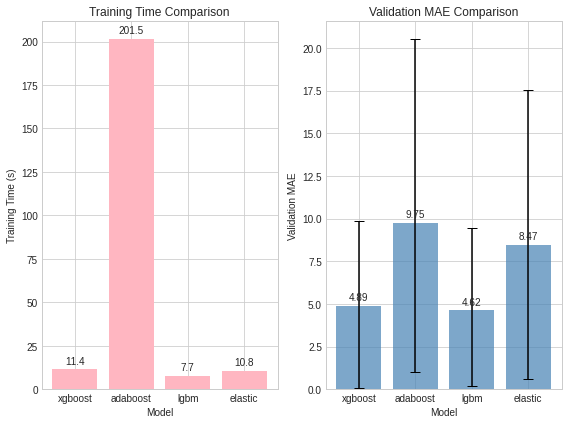

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'

# 定义模型名称和对应的训练时间、验证MAE
models = ['xgboost', 'adaboost', 'lgbm', 'elastic']
training_times = [11.390065670013428, 201.52103209495544, 7.726862668991089, 10.774928569793701]
validation_maes = [(4.891016764822686, 4.7887278, 4.993305769330431),
                   (9.747131501148274, 10.778602479313903, 8.715660522982644),
                   (4.622818994742742, 4.831269383461401, 4.414368606024082),
                   (8.467154096179167, 9.084146, 7.850162646398862)]

# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 创建画布和子图
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

# 绘制训练时间柱状图
axs[0].bar(models, training_times, color='lightpink')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Training Time (s)')
axs[0].set_title('Training Time Comparison')

# 添加训练时间柱状图的数值标签
for i, v in enumerate(training_times):
    axs[0].text(i, v + 2, str(round(v, 1)), ha='center', va='bottom')

# 绘制验证MAE柱状图
mae_mean = [np.mean(mae) for mae in validation_maes]
mae_min = [np.min(mae) for mae in validation_maes]
mae_max = [np.max(mae) for mae in validation_maes]
axs[1].bar(models, mae_mean, yerr=[mae_min, mae_max], capsize=5, color='steelblue', alpha=0.7)
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Validation MAE')
axs[1].set_title('Validation MAE Comparison')

# 添加验证MAE柱状图的数值标签
for i, v in enumerate(mae_mean):
    axs[1].text(i, v + 0.2, str(round(v, 2)), ha='center', va='bottom')

# 调整子图之间的间距
plt.tight_layout()

# 保存图片
plt.savefig('chart.png', dpi = 300)

# 显示图片
plt.show()


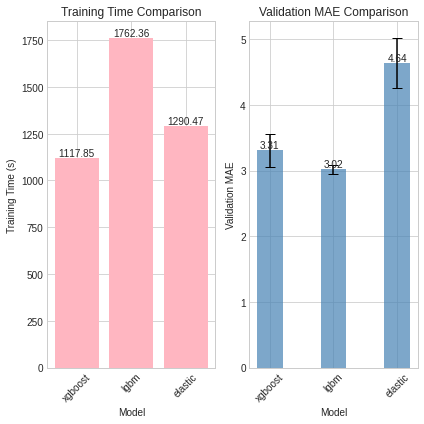

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'

# 定义模型名称和对应的训练时间、验证MAE
models = ['xgboost', 'lgbm', 'elastic']
training_times = [1117.85, 1762.36, 1290.47]
validation_maes = [(3.31, 3.06, 3.55),
                   (3.02, 2.94, 3.09),
                   (4.64, 5.02, 4.26)]

# 设置图表样式
plt.style.use('seaborn-whitegrid')

# 创建画布和子图
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))

# 绘制训练时间柱状图
axs[0].bar(models, training_times, color='lightpink')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Training Time (s)')
axs[0].set_title('Training Time Comparison')

# 添加训练时间柱状图的数值标签
for i, v in enumerate(training_times):
    axs[0].text(i, v, str(round(v, 2)), ha='center', va='bottom')

# 绘制验证MAE柱状图
mae_mean = [np.mean(mae) for mae in validation_maes]
mae_min = [np.clip(np.mean(mae)-np.min(mae), 0, None) for mae in validation_maes]   # 处理负数，使其不低于0
mae_max = [np.max(mae)-np.mean(mae) for mae in validation_maes]
bar_width = 0.4  # 设置柱状图的宽度

axs[1].bar(np.arange(len(models)), mae_mean, width=bar_width, yerr=[mae_min, mae_max], capsize=5, color='steelblue', alpha=0.7)
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Validation MAE')
axs[1].set_title('Validation MAE Comparison')

# 添加验证MAE柱状图的数值标签
for i, v in enumerate(mae_mean):
    axs[1].text(i, v, str(round(v, 2)), ha='center', va='bottom')

# 设置x轴刻度和标签
axs[1].set_xticks(np.arange(len(models)))
axs[1].set_xticklabels(models)

# 旋转横坐标上的标签
axs[0].tick_params(axis='x', rotation=45)
axs[1].tick_params(axis='x', rotation=45)

# 调整子图之间的间距
plt.tight_layout()

# 保存图片
plt.savefig('chart_full.png', dpi=300)

# 显示图片
plt.show()


In [ ]:
import pandas as pd

# 读取训练集的特征数据
traindata = pd.read_csv('/traindata.csv')

# 提取前10行数据
subset = traindata.head(10)

# 将提取的数据保存为新的 CSV 文件
subset.to_csv('subset_traindata.csv', index=False)